In [1]:
from sklearn.datasets import load_boston
boston = load_boston()

In [2]:
boston.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR'])

In [6]:
print(boston.DESCR)

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

In [2]:
import numpy as np
from time import time as t
import matplotlib.pyplot as plt
from pandas import DataFrame
from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'#to improve plot resolution

In [3]:
def SGD(x, y, n_iter = 1000, r=.001, batch_percent = 0.02):
    n_samples = x.shape[0]
    
    #randomly initializing weight vector with ndim=no.of features
    w = np.random.normal(0,1,x.shape[1])
    b = np.random.normal(0,1)
        
    for i in range(n_iter):
        temp_w = temp_b = 0
        #'k' i.e batch size
        k = int(n_samples * batch_percent)
        
        #picks a random set of k indices from train data
        batch = np.random.randint(n_samples,size=k)
        for j in batch:
            #from python3.5 PEP-0465 onwards '@' 
            #is dot product/matrix multiplication operator
            deriv = 2*(w@x[j] + b - y[j])
            temp_b += deriv#  dL/db = 2*(w.T*x[j] + b - y[j])
            temp_w += deriv * x[j]#  dL/dW = dL/db * x[j]
        w -= r * (temp_w/k)
        b -= r * (temp_b/k)
    return (w,b)

In [1]:
%load_ext cython

In [5]:
%%cython
#'%%cython' jupyter's magic function takes care of 
#compling and loading the shared object for cython
import numpy as np
cimport numpy as np

cdef cySGD(np.ndarray x,np.ndarray y,int n_iter = 1000,
           float r=.001,float batch_percent = 0.02):
    cdef:
        int i,j,n_samples = x.shape[0],
        k = int(n_samples * batch_percent),feats = x.shape[1]
        np.ndarray w = np.random.normal(0,1,feats) , 
        batch , temp_w = np.zeros(feats)
        double b = np.random.normal(0,1),temp_b,deriv
        
    for i in range(n_iter):
        temp_w = np.zeros(feats)
        temp_b = 0.0
        #picks a random set of k indices from train data
        batch = np.random.randint(n_samples,size=k)
        for j in batch:
            #from python3.5 PEP-0465 onwards 
            #'@' is dot product/matrix multiplication operator
            deriv = 2*(w@x[j] + b - y[j])
            temp_b += deriv#  dL/db = 2*(w.T*x[j] + b - y[j])
            temp_w += deriv * x[j]#  dL/dW = dL/db * x[j]
        w -= r * (temp_w/k)
        b -= r * (temp_b/k)
    return (w,b)

In [6]:
predict = lambda x,w,b:np.array([x[i]@w+b for i in range(x.shape[0])])

## *Testing with a dummy dataset:*

In [379]:
x1=list(range(1,20))
x2=[x1[i]+np.random.normal(0,1) for i in range(len(x1))]
y=[x1[i]+np.random.normal(0,1) for i in range(len(x1))]

In [380]:
df = DataFrame({'x1':x1,'x2':x2,'y':y})
df

,x1,x2,y
0,1,1.159256,1.952945
1,2,1.707344,2.622734
2,3,4.070746,1.413368
3,4,4.133119,4.088485
4,5,4.060577,5.165887
5,6,5.960416,4.371164
6,7,6.787406,5.865331
7,8,7.026555,8.357963
8,9,10.318042,9.244177
9,10,9.037655,9.964847


In [393]:
x_train, x_test, y_train, y_test = train_test_split(
    df[['x1','x2']].values, df.y.values, test_size=0.2)

In [406]:
w,b = SGD(x_train,y_train,1400)

In [389]:
lnr = LinearRegression()
lnr.fit(x_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [407]:
DataFrame({'actual_y':y_test,
           'predictd_y':predict(x_test,w,b),
           'sklearn':lnr.predict(x_test)})

,actual_y,predictd_y,sklearn
0,9.964847,10.187533,10.280230
1,14.669891,13.223899,14.098139
2,16.152469,15.665724,15.892196
3,19.292535,18.260099,19.489579


## *Testing on Boston House Pricing Dataset:*

In [7]:
x_train, x_test, y_train, y_test = train_test_split(
    boston.data,boston.target,test_size=0.1)
sclr = StandardScaler()
df_train = DataFrame(sclr.fit_transform(x_train))
df_test = DataFrame(sclr.transform(x_test))
df_train.columns = df_test.columns = boston.feature_names

In [24]:
df_train.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,-0.385055,-0.480099,-0.640641,-0.279641,-0.927061,-1.268195,0.951161,0.989270,-0.755647,-1.060926,-0.279290,0.448296,2.584599
1,-0.259317,-0.480099,-0.461661,-0.279641,-0.155306,-0.294574,1.120735,0.185782,-0.641117,-0.620953,1.170081,0.228732,0.050983
2,-0.408702,-0.480099,-1.149934,-0.279641,-0.575484,0.204533,-0.102363,-0.327455,-0.870177,-0.840939,-0.326044,0.396915,-0.552122
3,-0.113029,-0.480099,-0.205559,-0.279641,-0.103856,-1.884484,-1.123415,-0.599029,-0.641117,-0.638790,-0.045521,-0.057343,-0.006048
4,-0.387865,-0.480099,-0.640641,-0.279641,-0.927061,-0.355335,0.597581,0.903659,-0.755647,-1.060926,-0.279290,0.403011,0.872234


In [25]:
df_test.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,-0.395536,0.368396,-0.633365,-0.279641,-0.789860,-0.051531,-1.899126,0.306187,-0.755647,-1.120381,0.047987,0.448296,-0.868646
1,-0.403971,-0.480099,-0.073143,-0.279641,-1.227188,0.204533,-2.249098,0.713050,-0.641117,-0.632844,0.328510,0.304932,-0.850111
2,-0.403917,0.410820,-0.825441,-0.279641,-1.004236,-0.452263,-0.838386,1.437090,-0.641117,-1.001470,-0.793583,0.433709,0.109441
3,-0.394440,0.580519,-0.899653,-0.279641,-0.884186,-0.447923,0.882610,1.438891,-0.182997,-0.757701,0.562280,0.243428,0.250593
4,-0.407587,-0.480099,-1.149934,-0.279641,-0.575484,1.058079,0.626445,-0.171308,-0.870177,-0.840939,-0.326044,0.448296,-1.024056


## *Predicting Using My SGD:*

In [18]:
w,b = SGD(df_train.values,y_train,2000)

In [20]:
w

array([-0.66957688,  0.7303804 ,  0.14639272,  0.79393507, -1.11106481,
        2.87363814,  0.12217964, -1.7339175 ,  1.30554354, -0.93586999,
       -1.77497913,  0.88213049, -3.73360328])

In [21]:
b

22.072883127671236

## *Predicting Using Sklearn's Linear Regression:*

In [19]:
lnr = LinearRegression()
lnr.fit(df_train.values,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [22]:
lnr.coef_

array([-0.94461639,  1.24845339,  0.08378914,  0.76452298, -2.30788109,
        2.31848369,  0.11516817, -3.33659033,  2.76985003, -1.96087551,
       -2.03680852,  0.76570073, -4.02519866])

In [23]:
lnr.intercept_

22.457802197802206

## *Comparing My SGD with Sklearn Linear Regression:*

In [26]:
DataFrame({'actual_y':y_test,
           'predictd_y':predict(df_test.values,w,b),
           'sklearn':lnr.predict(df_test.values)}).head(10)

,actual_y,predictd_y,sklearn
0,25.2,25.874086,27.333480
1,24.2,24.815190,25.139698
2,19.7,21.005252,21.142751
3,16.0,18.466694,18.580061
4,23.6,30.106841,30.726405
5,25.3,24.818091,25.155528
6,8.5,15.562705,16.470726
7,19.0,20.781012,21.205720
8,29.0,30.894670,32.004414
9,14.4,3.677731,3.492780


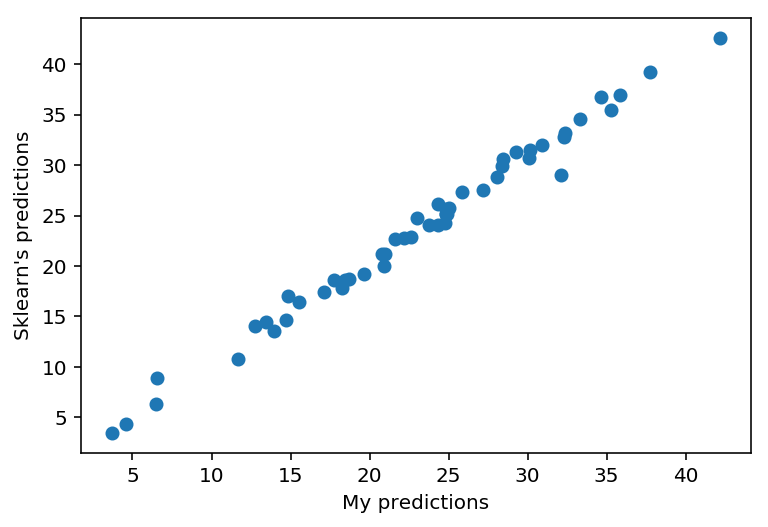

In [19]:
plt.scatter(x = predict(df_test.values,w,b), y = lnr.predict(df_test.values))
plt.xlabel('My predictions')
plt.ylabel('Sklearn\'s predictions')
plt.show()
# A straight line like plot would mean that 
#My predictions and Sklearn's predictions are almost near

## *Predicting Using Cython SGD:*

In [13]:
w,b = cySGD(df_train.values,y_train,2000)

In [15]:
w

array([-0.78798028,  0.87406054, -0.87678396,  0.92576034, -1.25537862,
        2.89920273, -0.18360376, -3.02887256,  0.93621482, -0.39217009,
       -1.76467665,  0.77387778, -3.68319882])

In [16]:
b

22.257252834112688

## *Comparing Cython SGD with Sklearn Linear Regression:*

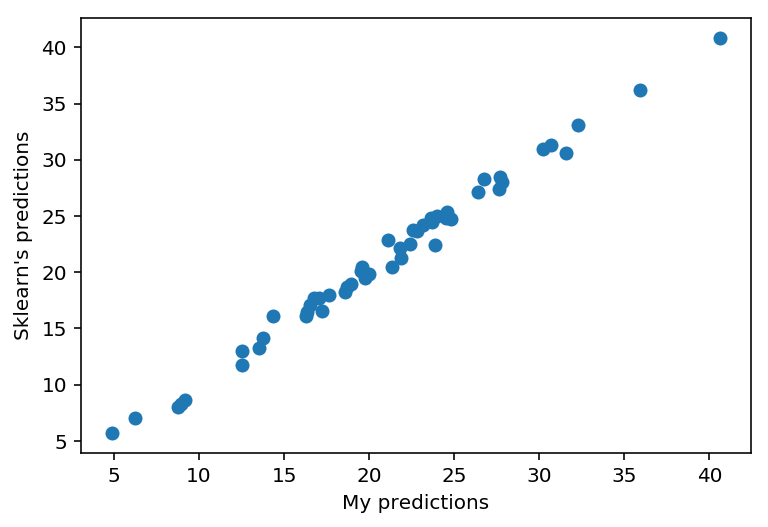

In [22]:
plt.scatter(x = predict(df_test.values,w,b), y = lnr.predict(df_test.values))
plt.xlabel('My predictions')
plt.ylabel('Sklearn\'s predictions')
plt.show()
# A straight line like plot would mean that 
#My predictions and Sklearn's predictions are almost near

## *Speed Comparision:*

In [9]:
%%timeit
#pure Python
w,b = SGD(df_train.values,y_train,2000)

80.1 ms ± 552 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [24]:
%%timeit
#Cython
w,b = cySGD(df_train.values,y_train,2000)

60.1 ms ± 256 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## *Gist of the Assignment:*

    first of all I want to mention that I really enjoyed a lot implementing an algorithm like SGD!
    
    for the data we used in assignments till now i.e text data there was features based on  
    frequency count so we didn't need to standard scalerize them 
    but the features in Boston House Pricing DataSet needs to be Standard Scalarized 
    else all weights and intercept increases exponentially.
    
    I know that Sklearn implements their algorithms in Cython internally so I also tried it in Cython
    there wasn't a remarkable speedup from pure python code to cython code , 
    that maybe because in both cases I used numpy arrays 
    but a small 20ms improvement can be observed that's because 
    python has to decide the type of a variable each time it encounters it at runtime but 
    on the other hand cython knows type of variables since I declared them beforehanded.